In [1]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

import os.path
import pickle
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib        as mpl
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics         import roc_curve

# Plot settings
mpl.rcParams['legend.frameon' ] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize' ] = 18
mpl.rcParams['axes.labelsize' ] = 18
mpl.rcParams['lines.linewidth'] = 2.5


# Useful functions
def remove_bjets_info(my_df):
    my_df = my_df.drop('nbjet',axis=1)
    jet_isb_list=['jet_isb'+str(i) for i in range(0,9)]
    my_df = my_df.drop(jet_isb_list,axis=1)
    return my_df

def save_model_in_file(model,filename):
    file = open(filename, 'wb')
    pickle.dump(model,file)
    file.close()
    return

def open_model_from_file(filename):
    file = open(filename, 'rb')
    model = pickle.load(file)
    file.close()
    return model

In [2]:
# Load tttt data
data = pd.read_csv('../data/4topSM.csv')
df = pd.DataFrame(data)
df = remove_bjets_info(df)

# Load ttV data
data_ttV = pd.read_csv('../data/ttV.csv')
df_ttV = pd.DataFrame(data_ttV)
df_ttV = remove_bjets_info(df_ttV)

In [3]:
# Features (observable space) and target (number to be predicted)
dataX = df.drop('m4top',axis=1)
dataY = df['m4top']

# Preparing cross validation samples
trainX, testX, trainY, testY = train_test_split(dataX, dataY, random_state=42, train_size=0.5)

In [6]:
# Train different algorithms

# 1. Random forest
if (os.path.exists('../data/random_forest_regression.dat')):
    rf_regre = open_model_from_file('../data/random_forest_regression.dat')
else:
    rf_regre = RandomForestRegressor(n_estimators=500,n_jobs=-1,max_depth=10).fit(trainX, trainY)
    save_model_in_file(rf_regre,'../data/random_forest_regression.dat')

# 2. Adaptative boosting
from sklearn.ensemble    import AdaBoostRegressor
from sklearn.tree        import DecisionTreeRegressor
if (os.path.exists('../data/adaboost_regression.dat')):
    ab_regre = open_model_from_file('../data/adaboost_regression.dat')
else:
    ab_regre = AdaBoostRegressor(n_estimators=500, base_estimator=DecisionTreeRegressor(max_depth=10)).fit(trainX, trainY)
    save_model_in_file(ab_regre,'../data/adaboost_regression.dat')

# 3. Gradient boosting
from sklearn.ensemble import GradientBoostingRegressor
if (os.path.exists('../data/gradboost_regression.dat')):
    gb_regre = open_model_from_file('../data/gradboost_regression.dat')
else:
    gb_regre = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=10).fit(trainX,trainY)
    save_model_in_file(gb_regre,'../data/gradboost_regression.dat')


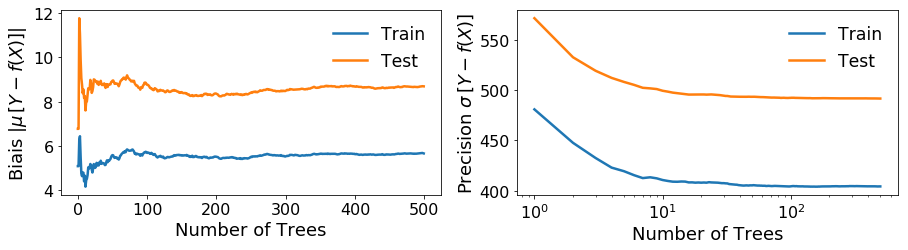

In [7]:
def plot_perf_randomforest_vs_ntree(rf_regre,trainX,trainY,testX,testY):

    plt.figure(figsize=(15,7.5))
    for sX, sY, label in [(trainX, trainY, 'Train'), (testX, testY, 'Test')]:
        predictions = np.zeros(len(sX))
        curve_rms   = []
        curve_mean  = []

        predictions = np.array( [tree.predict(sX) for tree in rf_regre.estimators_] )
        for i in range(0,rf_regre.n_estimators):
            if (i==0):
                Ypred=predictions[0]
            else:
                prediction_i = predictions[0:i]
                Ypred = np.average(prediction_i,axis=0)

            curve_rms .append( np.sqrt(np.var(Ypred-sY)) )
            curve_mean.append( np.abs(np.average(Ypred-sY)) )

        plt.subplot(221)
        plt.plot(curve_mean,label=label)
        plt.xlabel('Number of Trees')
        plt.ylabel('Biais $|\mu\,[Y-f(X)]|$')
        plt.legend()

        plt.subplot(222)
        plt.plot(curve_rms,label=label)
        plt.ylabel('Precision $\sigma\,[Y-f(X)]$')
        plt.xlabel('Number of Trees')
        plt.semilogx()
        plt.legend()

    return;


plot_perf_randomforest_vs_ntree(rf_regre,trainX,trainY,testX,testY)

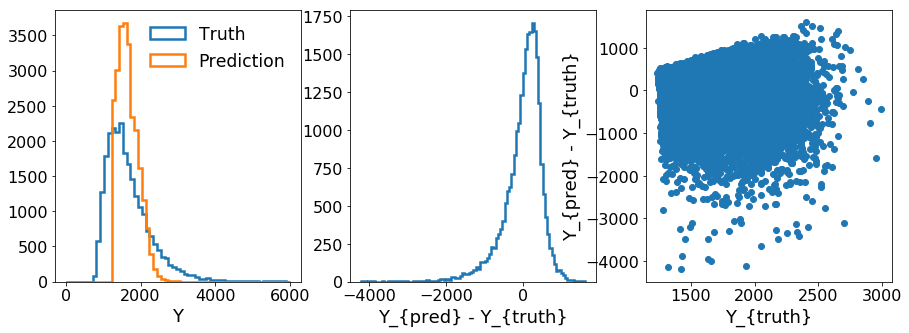

In [8]:
def plot_prediction_vs_truth(regressor,testX,testY):

    ypred = regressor.predict(testX)
    plt.figure(figsize=(15,5))
    
    plt.subplot(131)
    plt.xlabel('Y')
    plt.hist(testY, bins=np.linspace(0,6000,60), histtype='step', linewidth=2.5, label='Truth')
    plt.hist(ypred, bins=np.linspace(0,6000,60), histtype='step', linewidth=2.5, label='Prediction')
    plt.legend()

    plt.subplot(132)
    plt.xlabel('Y_{pred} - Y_{truth}')
    plt.hist(ypred-testY, bins=100, histtype='step', linewidth=2.5)

    plt.subplot(133)
    plt.xlabel('Y_{truth}')
    plt.ylabel('Y_{pred} - Y_{truth}')
    plt.plot(ypred,ypred-testY,'o')

    return

plot_prediction_vs_truth(rf_regre,testX,testY)

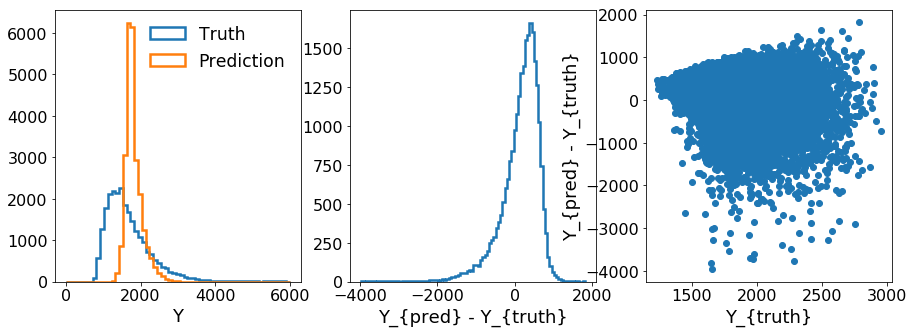

In [9]:
plot_prediction_vs_truth(ab_regre,testX,testY)

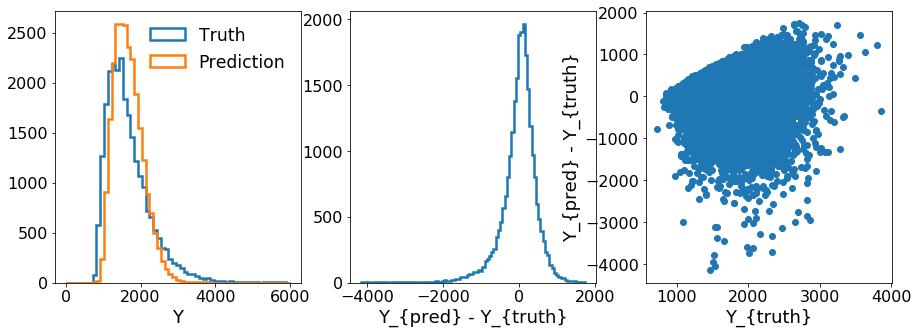

In [10]:
plot_prediction_vs_truth(gb_regre,testX,testY)

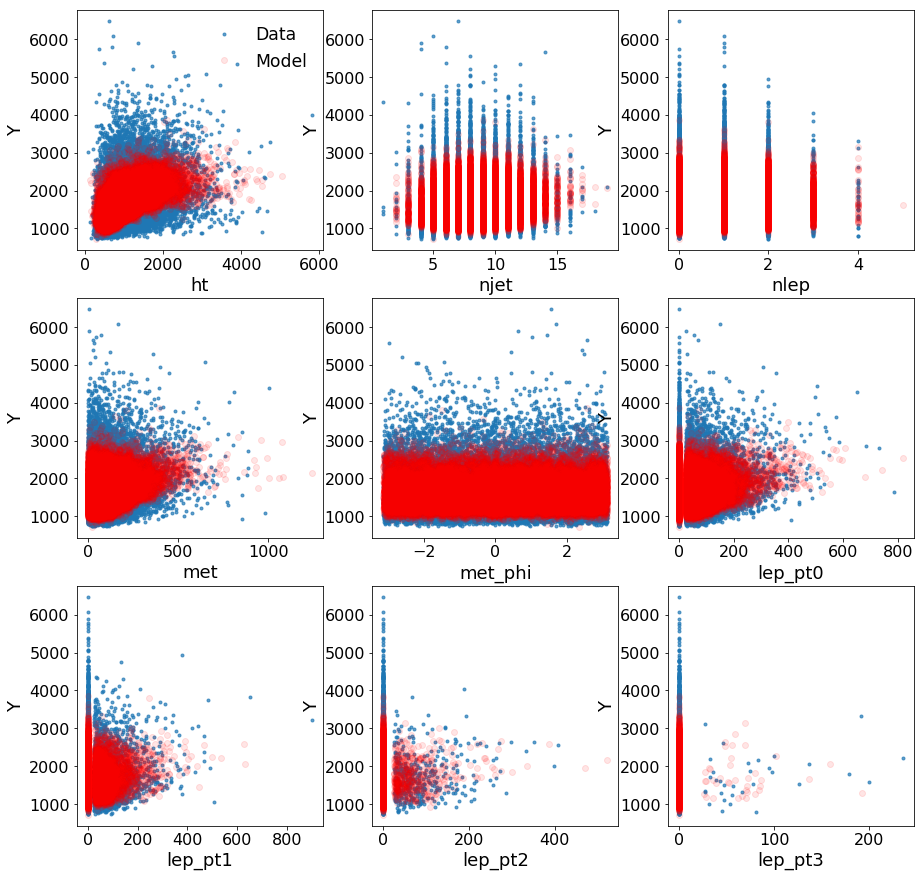

In [11]:
def plot_prediction_ndim(regressor,testX,testY,trainX,trainY,nvar=10):

    ypred=regressor.predict(testX)
    plt.figure(figsize=(15,15))

    i=0
    for varname in testX.columns[:nvar-1]:
        i=i+1
        x=testX[varname]
        plt.subplot(3,3,i)
        plt.plot(trainX[varname],trainY,'.',alpha=0.7, label='Data')
        plt.plot(testX[varname],ypred,'ro',alpha=0.1,label='Model')
        plt.ylabel('Y')
        plt.xlabel(varname)
        if (i==1):
            plt.legend()

    return

plot_prediction_ndim(gb_regre,testX,testY,trainX,trainY)

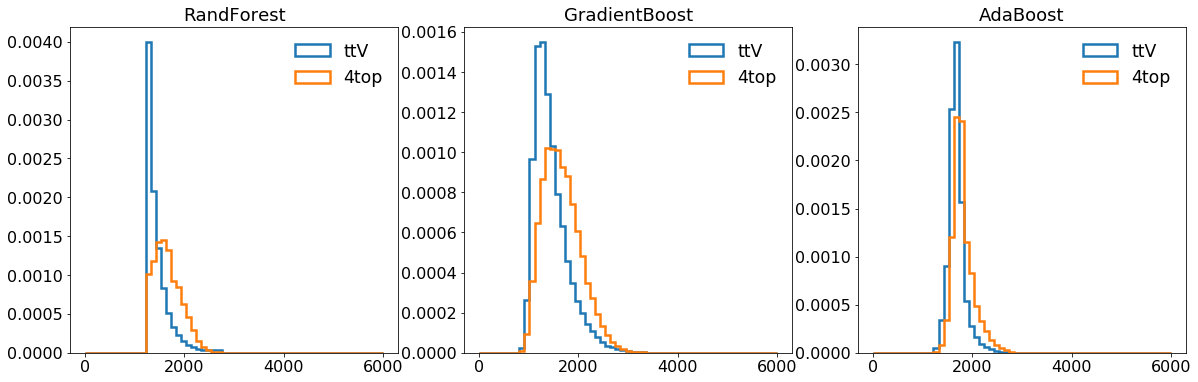

In [13]:
plt.figure(figsize=(20,6))
regressors=[[rf_regre,'RandForest'],[gb_regre,'GradientBoost'],[ab_regre,'AdaBoost']]
dataX_ttV = df_ttV.drop('m4top',axis=1)

i=0
for regre,name in regressors:
    i=i+1
    plt.subplot(1,3,i)
    plt.hist(regre.predict(dataX_ttV), density=True, bins=np.linspace(0,6000,60), histtype='step', linewidth=2.5, label='ttV')
    plt.hist(regre.predict(testX)    , density=True, bins=np.linspace(0,6000,60), histtype='step', linewidth=2.5, label='4top')
    plt.title(name)
    plt.legend()

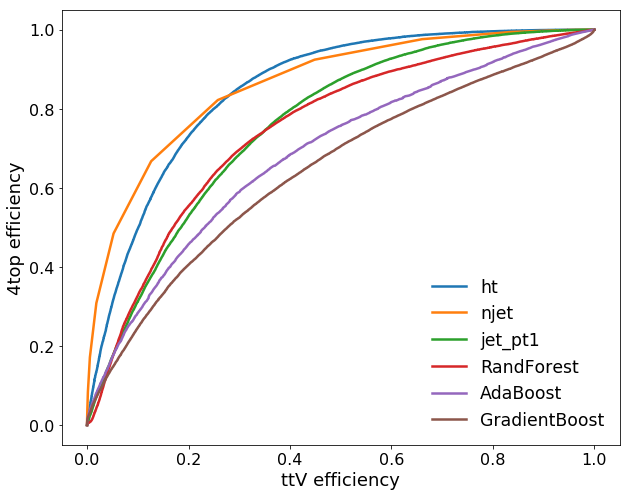

In [16]:
def plot_roc_curves(Xsig, Xbkg, variables, regressors, selections=''):

    # Prepare the full dataset
    sig_labelled = Xsig
    sig_labelled['isSig'] = True
    bkg_labelled = Xbkg
    bkg_labelled['isSig'] = False
    X = pd.concat( [sig_labelled,bkg_labelled] )
    X = X.query(selections)
    
    # Produce the plots
    plt.figure(figsize=(10,8))
    for var in variables:
        fake,eff,_= roc_curve(X['isSig'],X[var])
        plt.plot(fake,eff,label=var)
    
    Xeval=X.drop('isSig',axis=1)
    Xeval.head()
    for reg,name in regressors:
        fake,eff,_= roc_curve(X['isSig'],reg.predict(Xeval))
        plt.plot(fake,eff,label=name)
    
    plt.xlabel('ttV efficiency')
    plt.ylabel('4top efficiency')
    plt.legend()
    
    return


selection        = 'njet>0'
VariableToTest   = ['ht','njet','jet_pt1']
RegressorsToTest = [[rf_regre,'RandForest'],[ab_regre,'AdaBoost'],[gb_regre,'GradientBoost']]
plot_roc_curves(df.drop('m4top',axis=1),df_ttV.drop('m4top',axis=1), VariableToTest, RegressorsToTest,selection)